This is an example of merging precipitation data with the PFAS file. The precipitation data is for Orange County, 2010-2019 and was accessed from the NOAA Climate Data Online Search (https://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND)

In [79]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import math

def deg2rad(deg):
    return(deg*(math.pi/180.))
def getDistanceFromLatLonInKm(lat1,lon1,lat2,lon2):
    R=6371.
    dlat=deg2rad(lat2-lat1)
    dlon=deg2rad(lon2-lon1)
    a=math.sin(dlat/2.)*math.sin(dlat/2.) + math.cos(deg2rad(lat1)) *\
    math.cos(deg2rad(lat2)) *math.sin(dlon/2.)*math.sin(dlon/2.)

    b = 2. * math.atan2(math.sqrt(a),math.sqrt(1-a))
    d=R*b
    return(d)

prec=pd.read_csv("precip_2010_2019.csv")[['STATION','LATITUDE','LONGITUDE','ELEVATION','DATE','PRCP','TAVG','TMAX','TMIN']]
dat=pd.read_excel("SAR-Imperial_537Data_AsOf08-08-2019.xlsx",sheet_name='All')
location_data=pd.read_excel("SAR-Imperial_537Data_AsOf08-08-2019.xlsx",sheet_name='SAR-IMPERIAL-01 Location')
dat['latitude']=float(location_data['Latitude_WGS84'])
dat['longitude']=float(location_data['Longitude_WGS84'])

In [85]:
#Find the closest precip station to the PFAS station
prec_stations=prec[['STATION','LATITUDE','LONGITUDE']].drop_duplicates()
pfas_stations=dat[['Station Name','latitude','longitude']].drop_duplicates()
#Make table of distances
comb_dist=pd.DataFrame()
for s in pfas_stations['Station Name']:
    #Get the lat/lon coords for the station
    pfas_sub=pfas_stations[pfas_stations['Station Name']==s]
    pfas_lat=float(pfas_sub['latitude'])
    pfas_lon=float(pfas_sub['longitude'])
    for p in prec_stations['STATION']:
        prec_sub=prec_stations[prec_stations['STATION']==p]
        prec_lat=float(prec_sub['LATITUDE'])
        prec_lon=float(prec_sub['LONGITUDE'])
        dict_store={}
        dict_store['pfas_s']=s
        dict_store['prec_s']=p
        dict_store['dist_betw']=getDistanceFromLatLonInKm(pfas_lat,pfas_lon,prec_lat,prec_lon)
        comb_dist=comb_dist.append(dict_store,ignore_index=True)
#Find the min distance
min_dist=comb_dist.loc[comb_dist['dist_betw'].idxmin()]

In [89]:
#Merge the data by the date?
prec['DATE']=pd.to_datetime(prec['DATE'])
prec_tomerge=prec[prec['STATION']==str(min_dist['prec_s'])]
dat_merged=pd.merge(prec_tomerge,dat,left_on='DATE',right_on='Sample Date')

In [92]:
dat_sort=dat_merged.sort_values(by=['DATE'])
dat_sort.to_csv('SAR-Imperial_merged_precip.csv')

In [106]:
#Facet the data and plot 
dat_sub=dat_sort[['DATE','PRCP','Parameter Abbreviation','Result Value (10% of RDL for NDs)']]


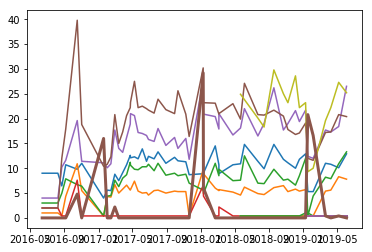

In [123]:
for p in dat_sub['Parameter Abbreviation'].unique():
    psub=dat_sub[dat_sub['Parameter Abbreviation']==p][['DATE','PRCP','Result Value (10% of RDL for NDs)']]
    plt.plot(psub['DATE'],psub['Result Value (10% of RDL for NDs)'])
    
plt.plot(dat_sub['DATE'],dat_sub['PRCP']*20,linewidth=3)